In [1]:
%load_ext autoreload

%autoreload 2
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.svm import SVC
 
from sklearn import metrics

from mlxtend.plotting import plot_decision_regions
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from ast import literal_eval

import warnings
import numpy as np
from collections import OrderedDict

from lob_data_utils import lob, db_result, model
from lob_data_utils.svm_calculation import lob_svm
import os
from scipy import stats


sns.set_style('whitegrid')
warnings.filterwarnings('ignore')

Using TensorFlow backend.


In [2]:
data_dir = 'res_prev_que_svm'
data_dir_que_log = '../queue_imbalance/res_que_log'
should_savefig = False

In [3]:
def convert(df_res, col):
    stocks_ = []
    for i, row in df_res.iterrows():
        s = row[col]
        if isinstance(s, int) or isinstance(s, np.float64) or isinstance(s, float):
            stocks_.append(s)
        elif isinstance(s, dict):
            stocks_.append(list(s.values())[0])
        else: 
            try:
                s = literal_eval(s)
                if isinstance(s, dict):
                    stocks_.append(list(s.values())[0])
                else:
                    stocks_.append(float(s))
            except Exception as e:
                print(col, s, e)
                stocks_.append(s)
    return stocks_

In [4]:
results_files = os.listdir(data_dir)
df_res = pd.DataFrame()
for f in results_files:
    if 'csv' not in f:
        continue
    df_res = df_res.append(pd.read_csv(os.path.join(data_dir, f)))

df_res.drop(columns=[c for c in df_res.columns if 'Unnamed' in c], inplace=True)

for c in df_res.columns:
    if c in ['kernel', 'features', 'coef0']:
        continue
    df_res[c] = convert(df_res, c)
df_res = df_res[df_res['matthews'] > 0]
df_res.head()

,C,coef0,f1,features,gamma,kappa,kernel,matthews,precision,recall,...,train_matthews,train_precision,train_recall,train_roc_auc,train_val_f1,train_val_kappa,train_val_matthews,train_val_precision,train_val_recall,train_val_roc_auc
9,0.01,NaN,0.388294,que_prev,0.10,0.142176,rbf,0.149338,0.387308,0.428926,...,0.124052,0.354643,0.576334,0.567901,0.378321,0.109175,0.116558,0.365037,0.435696,0.557245
10,0.01,NaN,0.429624,que_prev,1.00,0.140112,rbf,0.146683,0.362932,0.530300,...,0.127088,0.356939,0.571580,0.569518,0.424204,0.120590,0.127696,0.351811,0.538212,0.569468
11,0.01,NaN,0.411442,que_prev,10.00,0.137967,rbf,0.143540,0.372002,0.481668,...,0.136833,0.362731,0.570699,0.574773,0.413145,0.125682,0.133100,0.362945,0.503518,0.569055
15,0.10,NaN,0.413387,que_prev,0.01,0.144570,rbf,0.149280,0.374128,0.477732,...,0.123702,0.354281,0.577743,0.567717,0.405503,0.118405,0.123768,0.359480,0.484160,0.564630
16,0.10,NaN,0.423577,que_prev,0.10,0.144187,rbf,0.148949,0.369690,0.502402,...,0.125771,0.358439,0.553090,0.568631,0.416904,0.122371,0.127798,0.356735,0.509493,0.568394


In [5]:
df_best_rbf = df_res[df_res['kernel'] == 'rbf'].sort_values(
    by='matthews', ascending=False).groupby('stock').head(1)
df_best_lin = df_res[df_res['kernel'] == 'linear'].sort_values(
    by='matthews', ascending=False).groupby('stock').head(1)
df_best_sig = df_res[df_res['kernel'] == 'sigmoid'].sort_values(
    by='matthews', ascending=False).groupby('stock').head(1)

In [6]:
df_best = df_res.sort_values(by=['matthews', 'train_matthews'], ascending=False).groupby('stock').head(1)

## Distributions

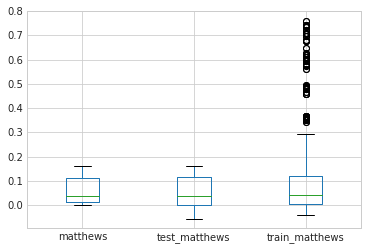

In [7]:
df_res[['matthews', 'test_matthews', 'train_matthews']].boxplot()

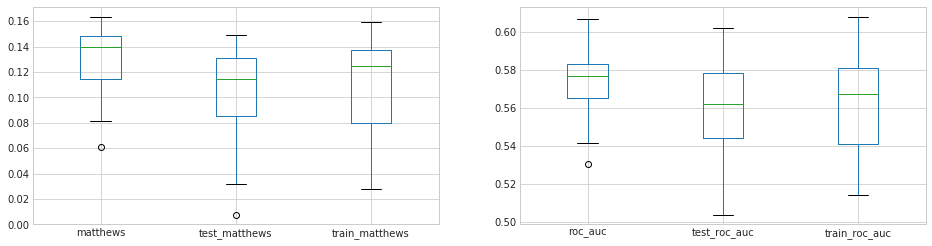

In [8]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 4))
df_best[['matthews', 'test_matthews', 'train_matthews']].boxplot(ax=ax1)
df_best[['roc_auc', 'test_roc_auc', 'train_roc_auc']].boxplot(ax=ax2)

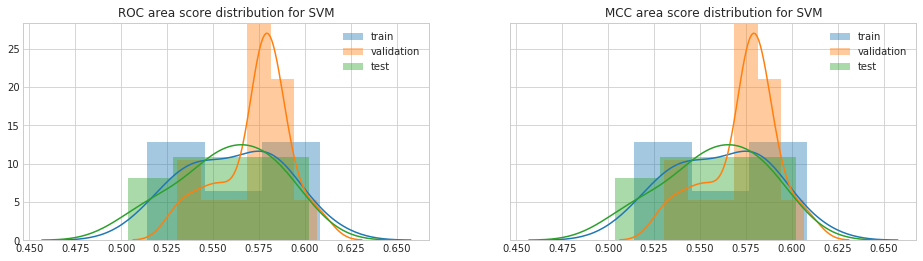

In [9]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 4), sharey=True)
sns.distplot(df_best[['train_roc_auc']], label='train', ax=ax1)
sns.distplot(df_best[['roc_auc']], label='validation', ax=ax1)
sns.distplot(df_best[['test_roc_auc']], label='test', ax=ax1)
ax1.set_title('ROC area score distribution for SVM')

sns.distplot(df_best[['train_roc_auc']], label='train', ax=ax2)
sns.distplot(df_best[['roc_auc']], label='validation', ax=ax2)
sns.distplot(df_best[['test_roc_auc']], label='test', ax=ax2)
ax2.set_title('MCC area score distribution for SVM')

ax1.legend()
ax2.legend()

### Per kernel

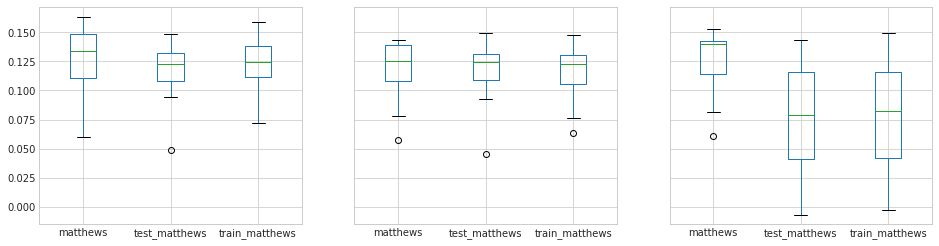

In [10]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(16, 4), sharey=True)
df_best_rbf[['matthews', 'test_matthews', 'train_matthews']].boxplot(ax=ax1)
df_best_lin[['matthews', 'test_matthews', 'train_matthews']].boxplot(ax=ax2)
df_best_sig[['matthews', 'test_matthews', 'train_matthews']].boxplot(ax=ax3)

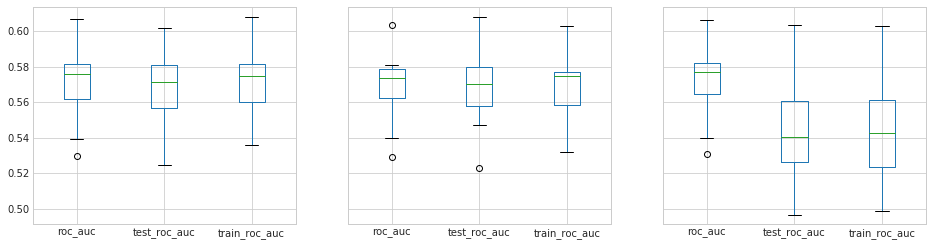

In [11]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(16, 4), sharey=True)
df_best_rbf[['roc_auc', 'test_roc_auc', 'train_roc_auc']].boxplot(ax=ax1)
df_best_lin[['roc_auc', 'test_roc_auc', 'train_roc_auc']].boxplot(ax=ax2)
df_best_sig[['roc_auc', 'test_roc_auc', 'train_roc_auc']].boxplot(ax=ax3)

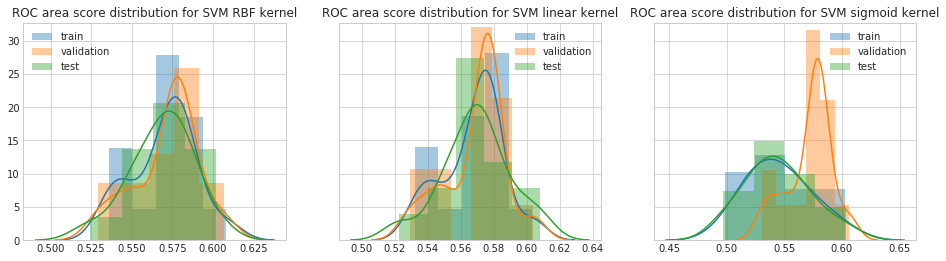

In [12]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(16, 4), sharey=True)
sns.distplot(df_best_rbf[['train_roc_auc']], label='train', ax=ax1)
sns.distplot(df_best_rbf[['roc_auc']], label='validation', ax=ax1)
sns.distplot(df_best_rbf[['test_roc_auc']], label='test', ax=ax1)
ax1.set_title('ROC area score distribution for SVM RBF kernel')

sns.distplot(df_best_lin[['train_roc_auc']], label='train', ax=ax2)
sns.distplot(df_best_lin[['roc_auc']], label='validation', ax=ax2)
sns.distplot(df_best_lin[['test_roc_auc']], label='test', ax=ax2)
ax2.set_title('ROC area score distribution for SVM linear kernel')

sns.distplot(df_best_sig[['train_roc_auc']], label='train', ax=ax3)
sns.distplot(df_best_sig[['roc_auc']], label='validation', ax=ax3)
sns.distplot(df_best_sig[['test_roc_auc']], label='test', ax=ax3)
ax3.set_title('ROC area score distribution for SVM sigmoid kernel')

ax1.legend()
ax2.legend()
ax3.legend()

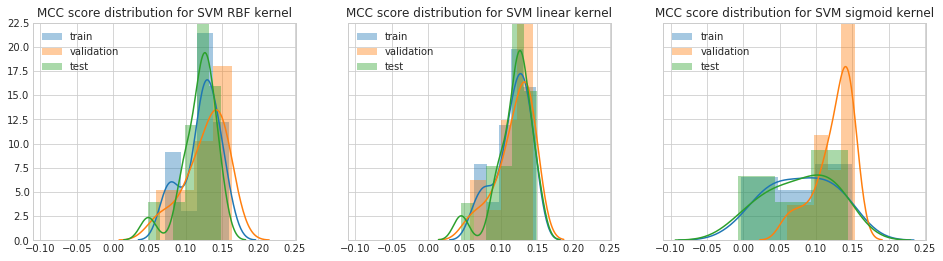

In [13]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(16, 4), sharey=True, sharex=True)
sns.distplot(df_best_rbf[['train_matthews']], label='train', ax=ax1)
sns.distplot(df_best_rbf[['matthews']], label='validation', ax=ax1)
sns.distplot(df_best_rbf[['test_matthews']], label='test', ax=ax1)
ax1.set_title('MCC score distribution for SVM RBF kernel')

sns.distplot(df_best_lin[['train_matthews']], label='train', ax=ax2)
sns.distplot(df_best_lin[['matthews']], label='validation', ax=ax2)
sns.distplot(df_best_lin[['test_matthews']], label='test', ax=ax2)
ax2.set_title('MCC score distribution for SVM linear kernel')

sns.distplot(df_best_sig[['train_matthews']], label='train', ax=ax3)
sns.distplot(df_best_sig[['matthews']], label='validation', ax=ax3)
sns.distplot(df_best_sig[['test_matthews']], label='test', ax=ax3)
ax3.set_title('MCC score distribution for SVM sigmoid kernel')

ax1.legend()
ax2.legend()
ax3.legend()

### Distributions without sigmoid

In [14]:
df_ker = df_res[df_res['kernel'] != 'sigmoid']
df_ker = df_ker.sort_values(by='matthews', ascending=False).groupby('stock').head(1)

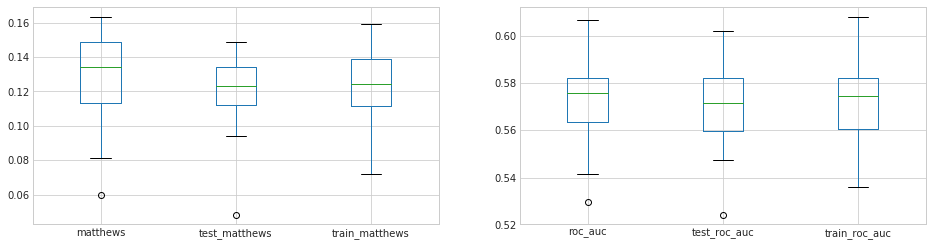

In [15]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 4))
df_ker[['matthews', 'test_matthews', 'train_matthews']].boxplot(ax=ax1)
df_ker[['roc_auc', 'test_roc_auc', 'train_roc_auc']].boxplot(ax=ax2)

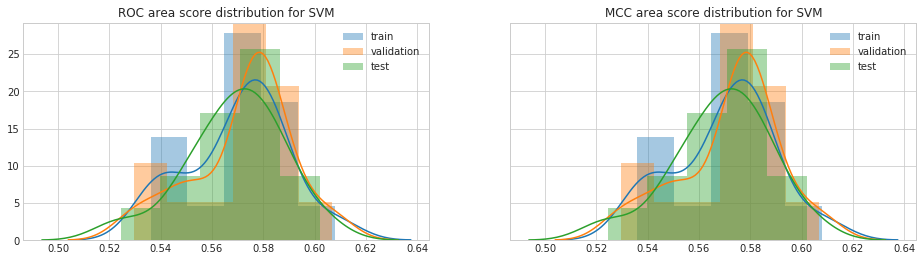

In [16]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 4), sharey=True)
sns.distplot(df_ker[['train_roc_auc']], label='train', ax=ax1)
sns.distplot(df_ker[['roc_auc']], label='validation', ax=ax1)
sns.distplot(df_ker[['test_roc_auc']], label='test', ax=ax1)
ax1.set_title('ROC area score distribution for SVM')

sns.distplot(df_ker[['train_roc_auc']], label='train', ax=ax2)
sns.distplot(df_ker[['roc_auc']], label='validation', ax=ax2)
sns.distplot(df_ker[['test_roc_auc']], label='test', ax=ax2)
ax2.set_title('MCC area score distribution for SVM')

ax1.legend()
ax2.legend()

## Compare with QUE+LOG

In [17]:
df_log = pd.DataFrame()
for f in os.listdir(data_dir_que_log):
    if 'csv' not in f:
        continue
    d = pd.read_csv(os.path.join(data_dir_que_log, f))
    df_log = df_log.append(d)

In [18]:
df_best = pd.merge(df_best, df_log, on='stock', suffixes=['', '_log'])
df_best.head()

,C,coef0,f1,features,gamma,kappa,kernel,matthews,precision,recall,...,train_matthews_log,train_precision_log,train_recall_log,train_roc_auc_log,train_val_f1_log,train_val_kappa_log,train_val_matthews_log,train_val_precision_log,train_val_recall_log,train_val_roc_auc_log
0,1000.0,NaN,0.270388,que_prev,0.01,0.142796,rbf,0.163370,0.280159,0.376750,...,0.105838,0.184566,0.580131,0.575084,0.263332,0.078054,0.108977,0.170085,0.593564,0.581752
1,1.0,NaN,0.412504,que_prev,0.10,0.149487,rbf,0.154382,0.382853,0.467075,...,0.125203,0.355774,0.572284,0.568501,0.429904,0.115188,0.124657,0.345005,0.570337,0.568988
2,1000.0,NaN,0.295478,que_prev,0.10,0.114590,rbf,0.149780,0.196501,0.611260,...,0.146106,0.208106,0.611383,0.601743,0.322562,0.123626,0.156452,0.219018,0.612914,0.607457
3,0.1,NaN,0.441832,que_prev,10.00,0.130463,rbf,0.149202,0.337824,0.639826,...,0.136130,0.350998,0.584954,0.575187,0.444664,0.129267,0.139997,0.357392,0.588589,0.577014
4,100.0,NaN,0.409936,que_prev,1.00,0.121177,rbf,0.148056,0.298709,0.664331,...,0.132427,0.295295,0.587389,0.577876,0.397318,0.120277,0.135691,0.301660,0.582024,0.579286


In [19]:
df_best_lin = pd.merge(df_best_lin, df_log, on='stock', suffixes=['', '_log'])
df_best_rbf = pd.merge(df_best_rbf, df_log, on='stock', suffixes=['', '_log'])
df_best_sig = pd.merge(df_best_sig, df_log, on='stock', suffixes=['', '_log'])

In [20]:
df_best['diff_test_matthews'] = df_best['test_matthews'] - df_best['test_matthews_log']
df_best['diff_test_matthews'].describe()

count    15.000000
mean     -0.016025
std       0.030380
min      -0.084917
25%      -0.026030
50%      -0.001299
75%       0.003777
max       0.007420
Name: diff_test_matthews, dtype: float64

### Regular comparision of scores

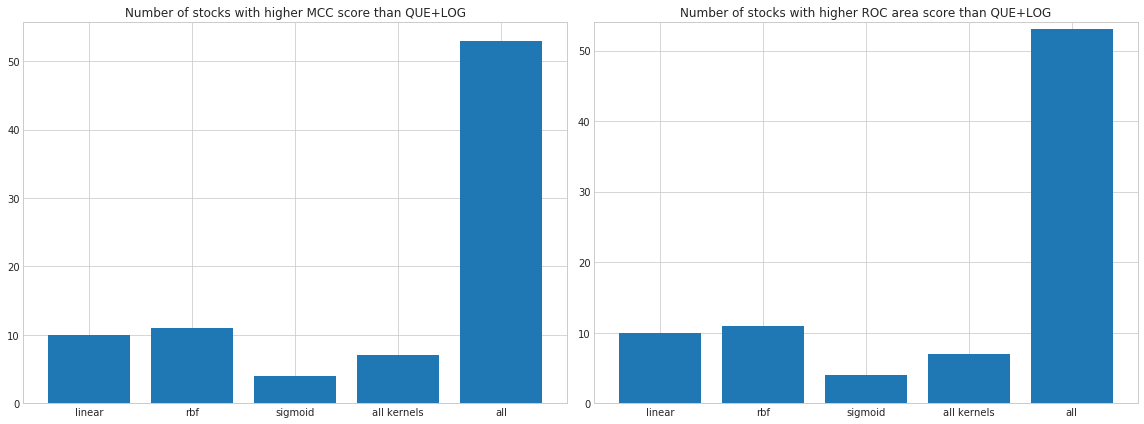

In [21]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

lin = len(df_best_lin[df_best_lin['test_matthews'] > df_best_lin['test_matthews_log']])
rbf = len(df_best_rbf[df_best_rbf['test_matthews'] > df_best_rbf['test_matthews_log']])
sig = len(df_best_sig[df_best_sig['test_matthews'] > df_best_sig['test_matthews_log']])
b = len(df_best[df_best['test_matthews'] > df_best['test_matthews_log']])
ax1.bar(['linear', 'rbf', 'sigmoid', 'all kernels', 'all'], [lin, rbf, sig, b, 53])
ax1.set_title('Number of stocks with higher MCC score than QUE+LOG')

lin = len(df_best_lin[df_best_lin['test_roc_auc'] > df_best_lin['test_roc_auc_log']])
rbf = len(df_best_rbf[df_best_rbf['test_roc_auc'] > df_best_rbf['test_roc_auc_log']])
sig = len(df_best_sig[df_best_sig['test_roc_auc'] > df_best_sig['test_roc_auc_log']])
b = len(df_best[df_best['test_roc_auc'] > df_best['test_roc_auc_log']])
ax2.bar(['linear', 'rbf', 'sigmoid', 'all kernels', 'all'], [lin, rbf, sig, b, 53])
ax2.set_title('Number of stocks with higher ROC area score than QUE+LOG')
plt.ylim(0, 54)
plt.ylim(0, 54)
plt.tight_layout()